
## 依赖包



In [ ]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

# from google.colab import drive
# drive.mount('/content/drive')   # 挂载云盘

plt.ion()   # interactive mode

## 下载及处理数据



In [ ]:
!rm -rf CNN
!git clone https://github.com/Zwysun/CNN.git
!ls

Cloning into 'CNN'...
remote: Enumerating objects: 687, done.
remote: Counting objects: 100% (687/687), done.
remote: Compressing objects: 100% (547/547), done.
remote: Total 687 (delta 157), reused 665 (delta 138), pack-reused 0
Receiving objects: 100% (687/687), 31.28 MiB | 19.93 MiB/s, done.
Resolving deltas: 100% (157/157), done.
CNN  sample_data


In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        # transforms.Grayscale(1),
        transforms.CenterCrop(1080),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        # transforms.Grayscale(1),
        transforms.CenterCrop(1080),
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'CNN/dataset/morning'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
print (dataset_sizes)
print (image_datasets)
print (class_names)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

{'train': 152, 'val': 38}
{'train': Dataset ImageFolder
    Number of datapoints: 152
    Root location: CNN/dataset/morning/train
    StandardTransform
Transform: Compose(
               CenterCrop(size=(1080, 1080))
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           ), 'val': Dataset ImageFolder
    Number of datapoints: 38
    Root location: CNN/dataset/morning/val
    StandardTransform
Transform: Compose(
               CenterCrop(size=(1080, 1080))
               Resize(size=224, interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )}
['0', '10', '15', '20', '25', '30', '35', '40', '45', '5', '50', '55', '60', '65', '70', '75', '80', '85', '90']
cuda:0


## 显示部分图片


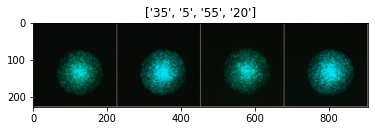

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['val']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## 训练模型



In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## 构建网络



In [ ]:
model_ft = models.densenet169(pretrained=True)
num_ftrs = model_ft.classifier.in_features
model_ft.classifier = nn.Linear(num_ftrs, 19, bias=True)
# model_ft.features.conv0 = nn.Conv2d(1, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False) # 输入参数修改

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
#print (model_ft)

Downloading: "https://download.pytorch.org/models/densenet169-b2777c0a.pth" to /root/.cache/torch/checkpoints/densenet169-b2777c0a.pth


In [ ]:
print (model_ft)

## 训练网络 + 输出




In [ ]:
 # 可视化，待修改
 
import torch
import tensorwatch as tw
from lanenet_model.blocks import ESPNet_Encoder # 这是我自己定义的一个网络
 
# 其实就两句话
model=ESPNet_Encoder()
tw.draw_model(model, [1, 3, 512, 256])

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=100)

Epoch 0/99
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 3.0491 Acc: 0.0855
val Loss: 3.0389 Acc: 0.1053

Epoch 1/99
----------
train Loss: 2.8567 Acc: 0.1250
val Loss: 2.2709 Acc: 0.2895

Epoch 2/99
----------
train Loss: 2.4066 Acc: 0.1908
val Loss: 1.6135 Acc: 0.5263

Epoch 3/99
----------
train Loss: 1.9698 Acc: 0.3618
val Loss: 1.9547 Acc: 0.3421

Epoch 4/99
----------
train Loss: 1.7940 Acc: 0.4737
val Loss: 1.1568 Acc: 0.6579

Epoch 5/99
----------
train Loss: 1.5393 Acc: 0.5000
val Loss: 1.8623 Acc: 0.2368

Epoch 6/99
----------
train Loss: 1.1628 Acc: 0.6776
val Loss: 0.4417 Acc: 0.8684

Epoch 7/99
----------
train Loss: 1.0110 Acc: 0.7566
val Loss: 0.4088 Acc: 0.9211

Epoch 8/99
----------
train Loss: 0.9763 Acc: 0.7829
val Loss: 0.3509 Acc: 0.8947

Epoch 9/99
----------
train Loss: 0.8695 Acc: 0.8289
val Loss: 0.3402 Acc: 0.9211

Epoch 10/99
----------
train Loss: 0.8296 Acc: 0.8487
val Loss: 0.2938 Acc: 0.9474

Epoch 11/99
----------
train Loss: 0.7568 Acc: 0.8355
val Loss: 0.3000 Acc: 0.9474

Epoch 12/99
----------
t

### 保存模型和参数

In [ ]:
os.chdir("/content")
!ls

cloth.pth  CNN	drive  light.pth  sample_data


In [ ]:
os.chdir("/content/drive/My Drive")
!ls
torch.save(model_ft,'light.pth')

'2020 年日历.gsheet'  'Colab Notebooks'  'Science Journal'


In [ ]:
demo = torch.load('cloth.pth')

In [ ]:
torch.save(demo.state_dict(), 'ELBOWDIC.pth')

In [ ]:
print (len(dataloaders['val']))

In [ ]:
#show acc
model = torch.load('cloth.pth')
eval_loss = 0.
eval_acc = 0.
s= 0.
with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for j in range(inputs.size()[0]):
                #s =s + int(class_names[preds[j]])
                #print(class_names[preds[j]])
                #if int(class_names[preds[j]]) == int(labels[j]):
                if class_names[preds[j]] == class_names[int(labels[j])]:
                    s = s+1
print (s)
print (s/(len(dataloaders['val']) * 4))


38.0
0.95
